# Ambertools-OpenMM Protein-ligand complex MD Setup tutorial using Jupyter Notebook
This notebook is wrritten by quantaosun@gmail.com in Shanghai, China, 2021. This notebook took PDB ID 7L10, the protease of SARS-CoV-2 with an inhibitor, as an example, relative work was firstly published on ACS Cent. Sci. 2021, 7, 3, 467–475, by William L. Jorgensen, Yale University.

Ambertools (https://ambermd.org/AmberTools.php) and Openmm (https://openmm.org/) should be properly refer to if any simulation result would be used in any publications.

In [1]:
#install openmm
!conda install -c conda-forge openmm -y
# install openmm-setup for protein fix and simulation configuration
!conda install -c conda-forge openmm-setup -y
#install open babel
!conda install -c openbabel openbabel -y
# install Amber tools
!conda install -c conda-forge ambertools=21 compilers -y 
#install visualization
! pip install py3Dmol 

Solving environment: done

## Package Plan ##

  environment location: /Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD

  added / updated specs:
    - openmm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openmm-7.7.0               |py37hf0bdc88_0_khronos         9.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.6 MB

The following packages will be UPDATED:

  openmm                       7.6.0-py37hf0bdc88_0_khronos --> 7.7.0-py37hf0bdc88_0_khronos



openmm-7.7.0         | 9.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD

  added / updated specs:
    - openmm-se

In [2]:
!conda env list

# conda environments:
#
base                     /Users/quantaosun/opt/anaconda3
Ambertools-OpenMM-MD  *  /Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD



In [3]:
import sys
sys.path.append('/home/sqt/anaconda3/envs/Ambertools-OpenMM-MD/lib/python3.7/site-packages')

# Download your PDB, if the command failed, just mannuly download and skip this.

In [6]:
PDB_ID = "7L10" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
wget https://files.rcsb.org/download/$pdb

zsh:1: command not found: wget


# Fix your protein with PDBfixer with OpenMM Setup

In [7]:
!pdbfixer
#Click the square pause button to force quit after finished.

PDBFixer running: http://localhost:8000 
^C
Traceback (most recent call last):
  File "/Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD/bin/pdbfixer", line 10, in <module>
    sys.exit(main())
  File "/Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD/lib/python3.7/site-packages/pdbfixer/pdbfixer.py", line 1212, in main
    ui.launchUI()
  File "/Users/quantaosun/opt/anaconda3/envs/Ambertools-OpenMM-MD/lib/python3.7/site-packages/pdbfixer/ui.py", line 282, in launchUI
    time.sleep(0.5)
KeyboardInterrupt


# Rename processed pdb to "output.pdb"

In [ ]:
#!mv 7L10-processed.pdb output.pdb

# Go to H++, register and process the output.pdb structure, download top and crd. If you leave everything default, you don't need to change anything below. http://newbiophysics.cs.vt.edu/H++/uploadpdb.php

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-02-08.png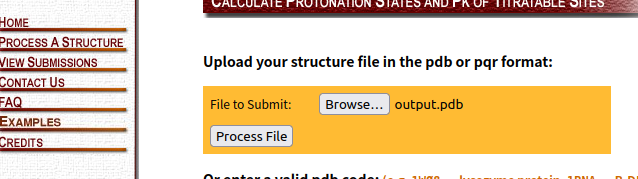

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-03-21.png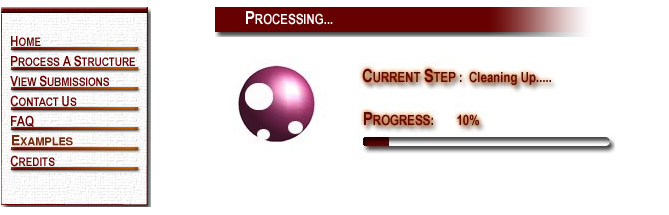

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-44-00.png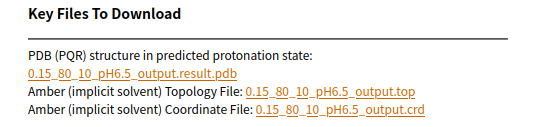

# It is assumed you have save the processed pdb with a name of "output.pdb", otherwise please modifiy commands below.

# Generate protein pdb

In [ ]:
!ambpdb -p 0.15_80_10_pH6.5_output.top -c 0.15_80_10_pH6.5_output.crd > 0.pdb

In [ ]:
!awk '$4=="XEY"' 7L10.pdb > ligand1.pdb 

# Add hydrogens to you ligand

In [ ]:
!obabel -ipdb ligand1.pdb -opdb -O ligand2.pdb -h

# Beautify pdb format

In [ ]:
!pdb4amber -i ligand2.pdb -o ligand3.pdb

# Generate ligand mol2 file

In [ ]:
!antechamber -fi pdb -i ligand3.pdb -fo mol2 -o ligand4.mol2 -c bcc -pf y

# Make sure you see "calculation completed", otherwise something may have been wrong

In [ ]:
!tail  sqm.out

# Generate ligand prepi file

In [ ]:
!antechamber -i ligand4.mol2 -fi mol2 -o ligand5.prepi -fo prepi -pf y

# Generate ligand frcmod file

In [ ]:
!parmchk2 -f prepi -i ligand5.prepi -o ligand6.frcmod

# Combine protein with ligand again

In [ ]:
!cat 0.pdb ligand3.pdb > complex.pdb

# (Not working properly for now) Beautify PDB format, but we might just not need this anyway, skip for now.

In [ ]:
#!pdb4amber -i complex.pdb -o complex_clean.pdb
# This step is problematic for now, it has been observed it is not necessary or even could bring errors to next step.

# Create and run a file called tleap.in with Ambertools

In [ ]:
com_file = open('tleap.in','w')
com_file.write('''
source leaprc.protein.ff14SB #Source leaprc file for ff14SB protein force field
source leaprc.gaff #Source leaprc file for gaff
source leaprc.water.tip3p #Source leaprc file for TIP3P water model
loadamberprep ligand5.prepi #Load the prepi file for the ligand
loadamberparams ligand6.frcmod #Load the additional frcmod file for ligand
mol = loadpdb complex.pdb #Load PDB file for protein-ligand complex
solvatebox mol TIP3PBOX 8 #Solvate the complex with a cubic water box
addions mol Cl- 0 #Add Cl- ions to neutralize the system
saveamberparm mol complex.prmtop complex.inpcrd #Save AMBER topology and coordinate files
quit #Quit tleap program
''')
com_file.close()
!tleap -s -f tleap.in > tleap.out

# Upload prmtop and inpcrd to openmm-setup, and start the simulation! If you have a proper GPU, select CUDA, otherwise select CPU.

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-00-12.png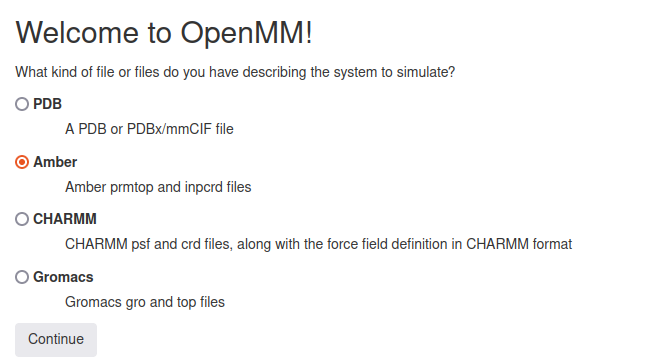

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2011-01-00.png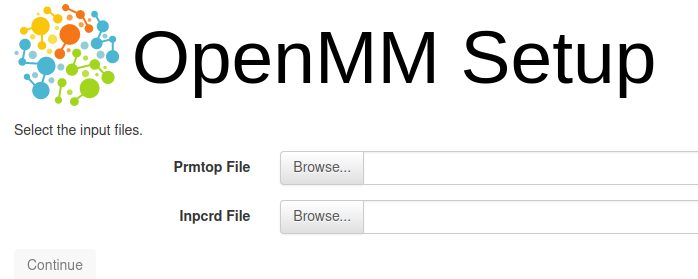

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2012-02-57.png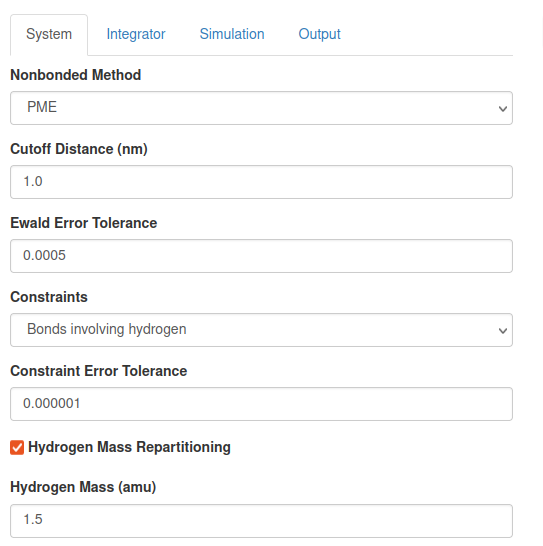

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2012-03-57.png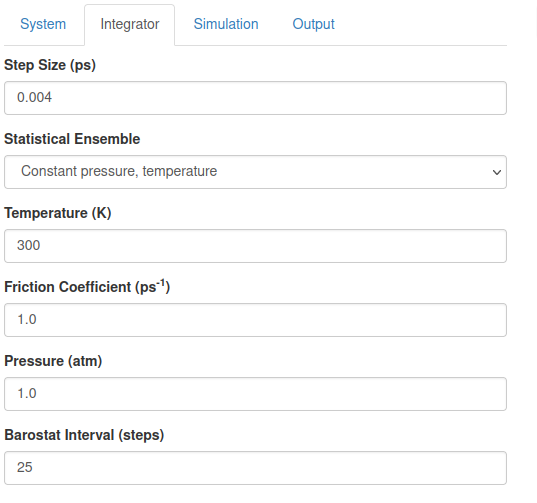

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2012-04-37.png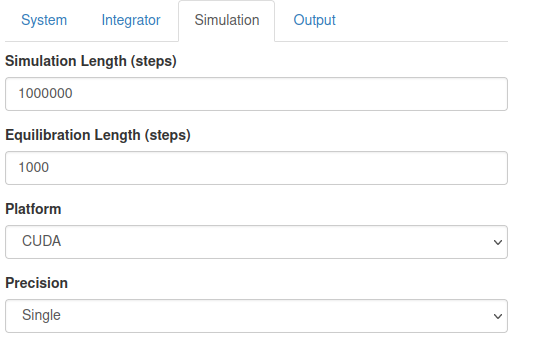

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2012-05-08.png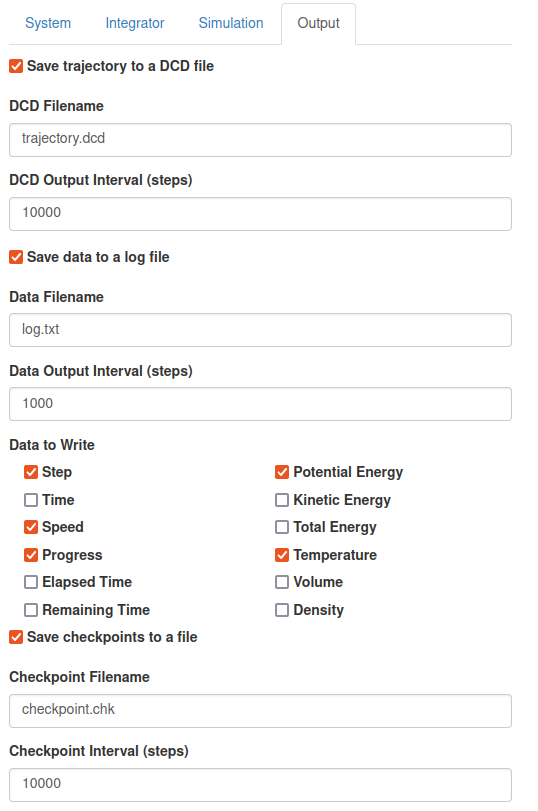

# You could leave all parameters by default and click "Run Simulation"

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2012-05-36.png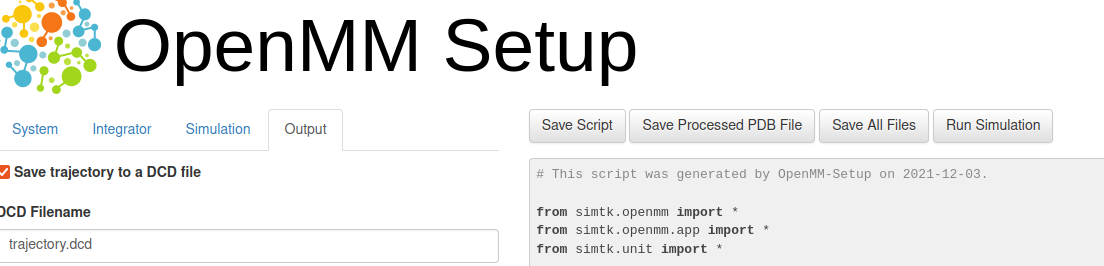

# Click "Start"

file:///home/sqt/Pictures/Screenshot%20from%202021-12-03%2012-06-44.png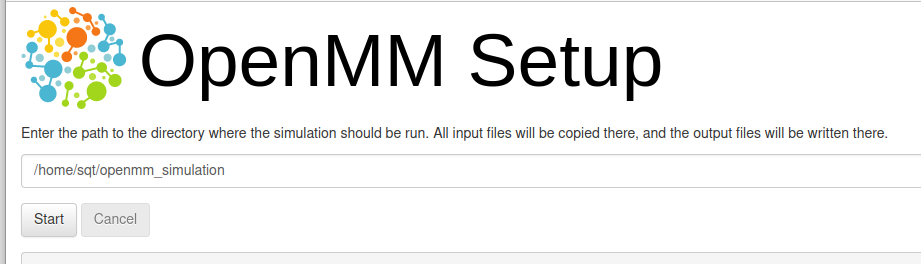

In [ ]:
!openmm-setup
#Click the square pause button to force quit after finished.

# If all goes well, you should see something like below (CPU only).

In [ ]:
Building system...
Performing energy minimization...
Equilibrating...
Simulating...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"
0.1%	1000	-488259.139341292	298.57624202824957	0
0.2%	2000	-492082.04384769656	300.09275305741824	16.6
0.3%	3000	-494725.1462343714	302.3090730320394	16.6
0.4%	4000	-496075.06792005355	302.3939891905172	16.4
0.5%	5000	-498015.23323377833	300.135566206444	16.4
0.6%	6000	-498488.50188332796	298.5545999644654	16.3
0.7%	7000	-499572.9765659773	300.7757759109986	16.3
0.8%	8000	-499030.79245316726	297.2492234858693	16.2
0.9%	9000	-499823.2656625096	300.60293949805	16.2
1.0%	10000	-500134.98822511156	297.5748675220697	16.2
1.1%	11000	-499849.7045947542	300.5532217535929	16.2
1.2%	12000	-500542.2799043103	299.2530600741315	16.2

# Alternatively, you could save the simulation input files and run it on a cloud or HPC based OpenMM with GPU acceleration, an example script would be :

In [ ]:
# This script was generated by OpenMM-Setup on 2021-12-15.

from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *

# Input Files

prmtop = AmberPrmtopFile('complex.prmtop')
inpcrd = AmberInpcrdFile('complex.inpcrd')

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 1000000
equilibrationSteps = 1000
platform = Platform.getPlatformByName('CPU')
dcdReporter = DCDReporter('trajectory.dcd', 10000)
dataReporter = StateDataReporter('log.txt', 1000, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t')
checkpointReporter = CheckpointReporter('checkpoint.chk', 10000)

# Prepare the Simulation

print('Building system...')
topology = prmtop.topology
positions = inpcrd.positions
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate

print('Simulating...')
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(checkpointReporter)
simulation.currentStep = 0
simulation.step(steps)

If you could access AI Studio, you could consider to fork my project there https://aistudio.baidu.com/aistudio/projectdetail/2694076?contributionType=1 , it provide free Tesla V100 GPU at the time when this tutorial is written.

# Below this cell was added in 2022.

## MMPBSA to estimate the binding energy of protein and small molecule.

In [ ]:
ante-MMPBSA.py  -p complex.prmtop -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii mbondi2 

In [ ]:
f = open("mmpbsa.in", "w")
f.write("""&general """  + "\n"
"""  endframe=""" + """,  interval=""" + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
"""/ """ + "\n"
"""&gb """ + "\n"
""" igb=""" +  """, saltcon=""" +  """, """ + "\n"
"""/""")
f.close()

Please use Pymol to visulize how many dcd frames you got, then change the mmpbsa.in accordingly. mmpbsa.in examples can be found https://ambermd.org/doc12/Amber21.pdf 

In [ ]:
MMPBSA.py -O -i mmpbsa.in -o FINAL_RESULTS_MMPBSA_decomposition.dat -sp  complex.prmtop -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y prot_lig_prod_all.dcd

# The above mmpbsa.in only runs GBSA calculation, for the sake of time.